In [ ]:
!pip install tensorflow

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Flatten, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.initializers import Constant
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from google.colab import drive

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

drive.mount('/content/drive') # Mount Google Drive to access the file

# Load dataset
file_path = '/content/drive/MyDrive/NLP/balanced_job_dataset.csv'
data = pd.read_csv(file_path)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Mounted at /content/drive


In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Text cleaning and tokenization function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Apply preprocessing to text data
data['processed_text'] = data['Description'].apply(preprocess_text)

# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['Relevance'])

# Split data into train/test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['processed_text'], data['label'], test_size=0.2, random_state=42)

In [ ]:
# Tokenize text data
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

# Convert texts to sequences and pad them
X_train = pad_sequences(tokenizer.texts_to_sequences(train_texts), maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_texts), maxlen=max_len)

# Load GloVe embeddings (optional)
def load_glove_embeddings(glove_path):
    embeddings_index = {}
    with open(glove_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Try loading GloVe embeddings
try:
    glove_path = '/content/drive/MyDrive/NLP/glove.6B.100d.txt'
    glove_embeddings = load_glove_embeddings(glove_path)

    embedding_dim = 100
    embedding_matrix = np.zeros((max_words, embedding_dim))

    for word, i in tokenizer.word_index.items():
        if i < max_words:
            embedding_vector = glove_embeddings.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    use_glove = True
except:
    print("GloVe embeddings not found, using learned embeddings instead")
    use_glove = False

GloVe embeddings not found, using learned embeddings instead


In [ ]:
# MLP Model
def create_mlp_model():
    model = Sequential()
    if use_glove:
        model.add(Embedding(max_words, embedding_dim,
                         embeddings_initializer=Constant(embedding_matrix),
                         input_length=max_len,
                         trainable=False))
    else:
        model.add(Embedding(max_words, 128, input_length=max_len))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# LSTM Model
def create_lstm_model():
    model = Sequential()
    if use_glove:
        model.add(Embedding(max_words, embedding_dim,
                         embeddings_initializer=Constant(embedding_matrix),
                         input_length=max_len,
                         trainable=False))
    else:
        model.add(Embedding(max_words, 128, input_length=max_len))

    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# CNN Model
def create_cnn_model():
    model = Sequential()
    if use_glove:
        model.add(Embedding(max_words, embedding_dim,
                         embeddings_initializer=Constant(embedding_matrix),
                         input_length=max_len,
                         trainable=False))
    else:
        model.add(Embedding(max_words, 128, input_length=max_len))

    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Create and train models
mlp_model = create_mlp_model()
lstm_model = create_lstm_model()
cnn_model = create_cnn_model()

print("Training MLP Model...")
mlp_history = mlp_model.fit(X_train, train_labels,
                           validation_data=(X_test, test_labels),
                           epochs=5, batch_size=64)

print("\nTraining LSTM Model...")
lstm_history = lstm_model.fit(X_train, train_labels,
                             validation_data=(X_test, test_labels),
                             epochs=5, batch_size=64)

print("\nTraining CNN Model...")
cnn_history = cnn_model.fit(X_train, train_labels,
                           validation_data=(X_test, test_labels),
                           epochs=5, batch_size=64)

# Save models
mlp_model.save('mlp_text_classification.h5')
lstm_model.save('lstm_text_classification.h5')
cnn_model.save('cnn_text_classification.h5')
print("\nModels saved successfully.")

Training MLP Model...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.3483 - loss: 0.3242 - val_accuracy: 0.3950 - val_loss: -0.6769
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3306 - loss: -0.1208 - val_accuracy: 0.3950 - val_loss: -1.1601
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3079 - loss: -0.6488 - val_accuracy: 0.3950 - val_loss: -2.6311
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3146 - loss: -3.1925 - val_accuracy: 0.3950 - val_loss: -10.2058
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3255 - loss: -12.4697 - val_accuracy: 0.3950 - val_loss: -31.7378

Training LSTM Model...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 373ms/step - accuracy: 0.3204 - loss: 0.5747 - val_accuracy: 0.3950 - val_loss: -0.2652
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.3100 - loss: 0.0964 - val_accuracy: 0.3950 - val_loss: -0.2903
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.3144 - loss: -0.0149 - 


Models saved successfully.


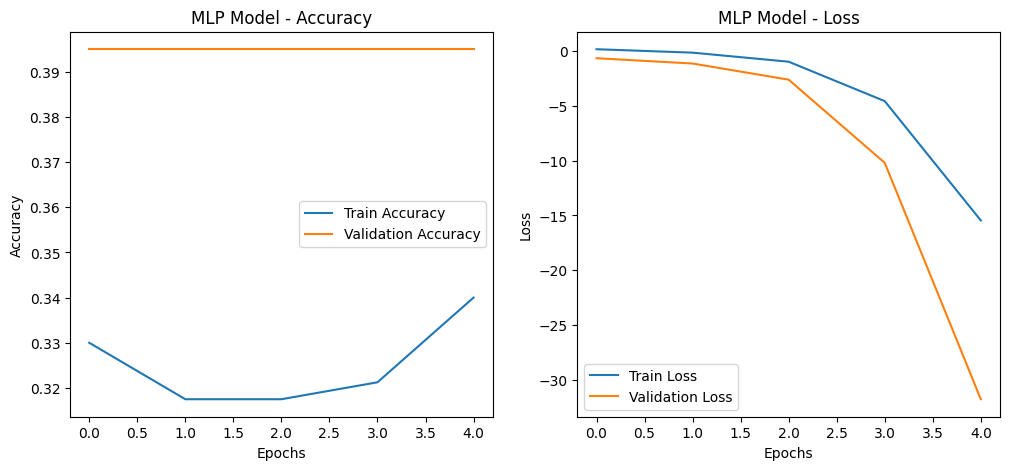

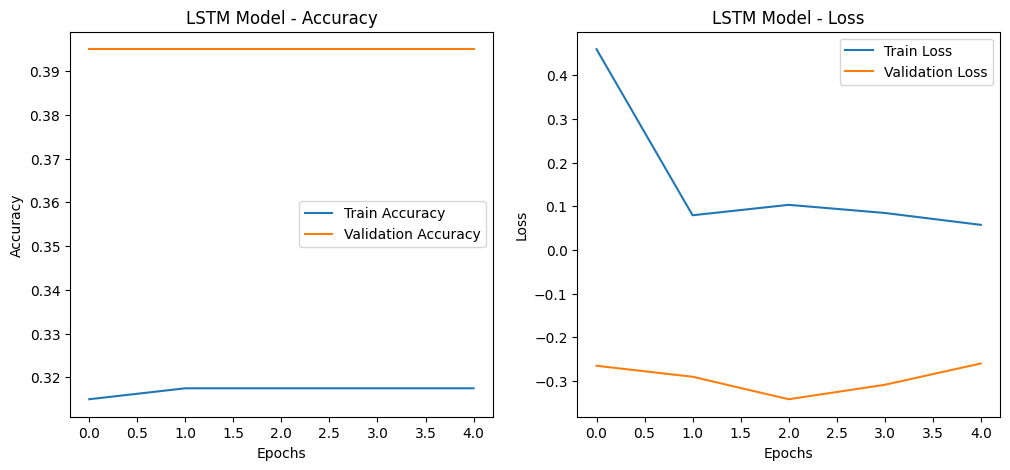

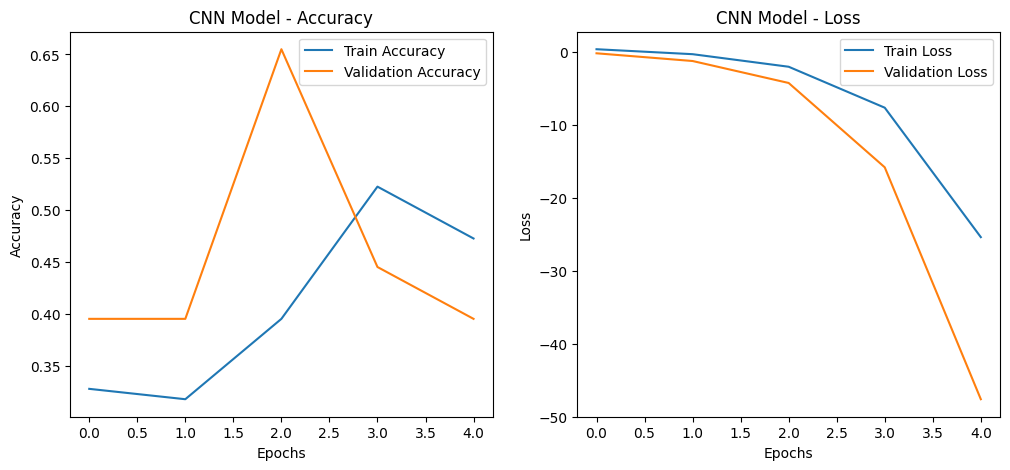

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

MLP Evaluation:
Accuracy: 0.3950
Classification Report:
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00        53
      Medium       0.40      1.00      0.57        79
      Strong       0.00      0.00      0.00        68

    accuracy                           0.40       200
   macro avg       0.13      0.33      0.19       200
weighted avg       0.16      0.40      0.22       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step

LSTM Evaluation:
Accuracy: 0.3950
Classification Report:
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00        53
      Medium       0.40      1.00      0.57        79
      Strong       0.00      0.00      0.00        68

    accuracy                           0.40       200
   macro avg       0.13      0.33      0.19       200
weighted avg       0.16      0.40      0.22       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step

CNN Evaluation:
Accuracy: 0.3950
Classification Report:
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00        53
      Medium       0.40      1.00      0.57        79
      Strong       0.00      0.00      0.00        68

    accuracy                           0.40       200
   macro avg       0.13      0.33      0.19       200
weighted avg       0.16      0.40      0.22       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def plot_training_results(history, title):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

# Plot results
plot_training_results(mlp_history, "MLP Model")
plot_training_results(lstm_history, "LSTM Model")
plot_training_results(cnn_history, "CNN Model")

# Evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)

    return accuracy

# Evaluate all models
mlp_acc = evaluate_model(mlp_model, X_test, test_labels, "MLP")
lstm_acc = evaluate_model(lstm_model, X_test, test_labels, "LSTM")
cnn_acc = evaluate_model(cnn_model, X_test, test_labels, "CNN")

In [ ]:
def preprocess_new_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Example inputs
real_world_inputs = [
    "Looking for a data scientist with Python and machine learning skills",
    "Marketing manager position for social media campaigns",
    "Backend developer needed with Django and PostgreSQL experience"
]

def predict_all_models(texts):
    processed_inputs = [preprocess_new_text(text) for text in texts]
    X_real = pad_sequences(tokenizer.texts_to_sequences(processed_inputs), maxlen=max_len)

    # Get predictions
    mlp_preds = mlp_model.predict(X_real)
    lstm_preds = lstm_model.predict(X_real)
    cnn_preds = cnn_model.predict(X_real)

    # Convert to labels
    mlp_labels = label_encoder.inverse_transform((mlp_preds > 0.5).astype(int).flatten())
    lstm_labels = label_encoder.inverse_transform((lstm_preds > 0.5).astype(int).flatten())
    cnn_labels = label_encoder.inverse_transform((cnn_preds > 0.5).astype(int).flatten())

    # Create results
    results = pd.DataFrame({
        "Input Text": texts,
        "MLP Prediction": mlp_labels,
        "LSTM Prediction": lstm_labels,
        "CNN Prediction": cnn_labels
    })

    return results

# Get and display predictions
real_world_results = predict_all_models(real_world_inputs)
print("\nReal-world Predictions:")
print(real_world_results)

# Model comparison
print("\nModel Accuracies:")
print(f"MLP: {mlp_acc:.4f}")
print(f"LSTM: {lstm_acc:.4f}")
print(f"CNN: {cnn_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

Real-world Predictions:
                                          Input Text MLP Prediction  \
0  Looking for a data scientist with Python and m...         Medium   
1  Marketing manager position for social media ca...         Medium   
2  Backend developer needed with Django and Postg...         Medium   

  LSTM Prediction CNN Prediction  
0          Medium         Medium  
1          Medium         Medium  
2          Medium         Medium  

Model Accuracies:
MLP: 0.3950
LSTM: 0.3950
CNN: 0.3950


# **Exploratory Data Analysis (EDA)**

In [ ]:
!pip install matplotlib seaborn wordcloud scikit-learn

🎯 TARGET CLASS DISTRIBUTION


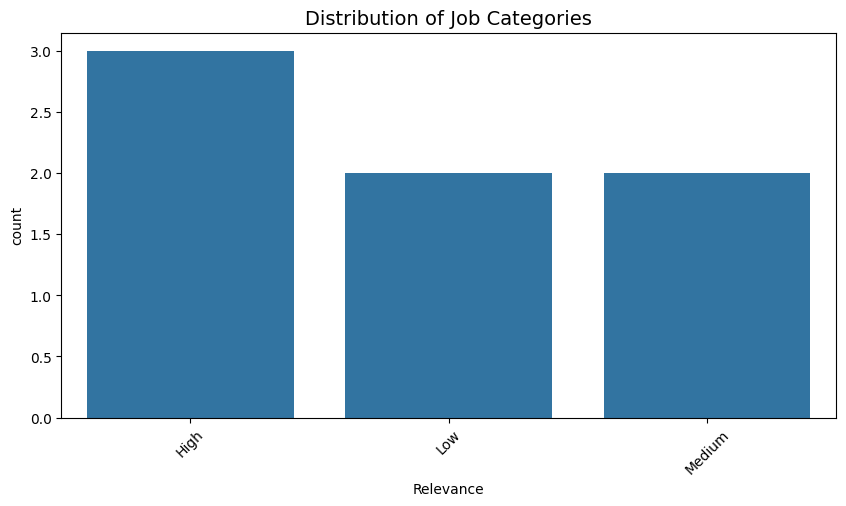


📏 TEXT LENGTH ANALYSIS


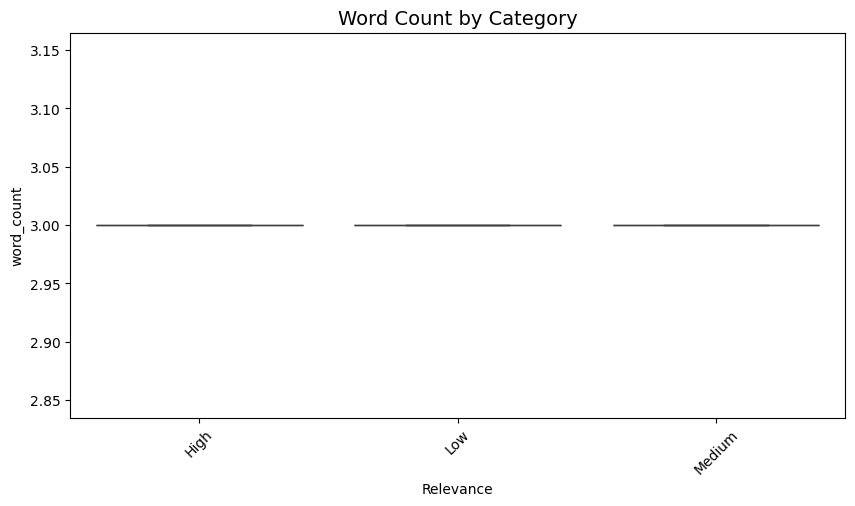

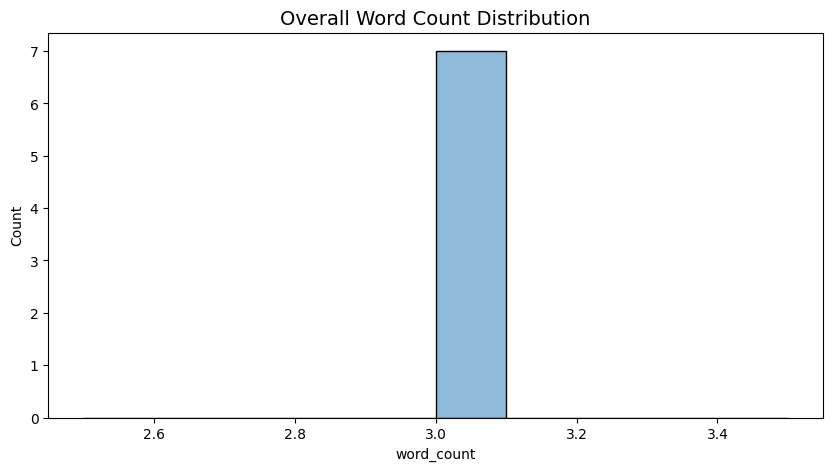


☁️ WORD CLOUD FOR 'High' CATEGORY


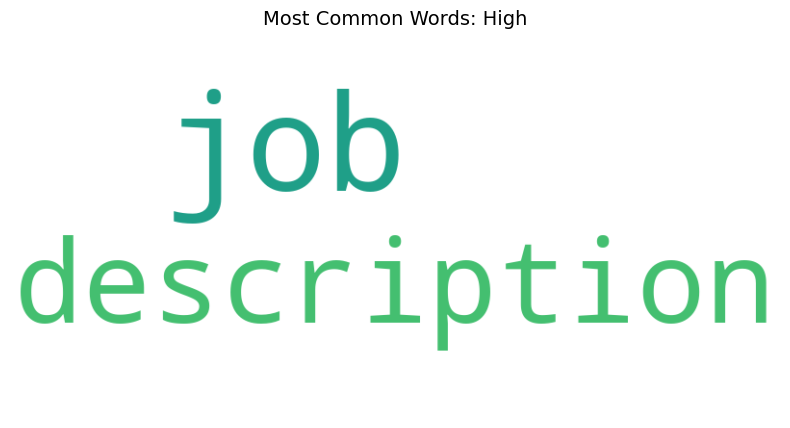


🔑 TOP KEYWORDS BY CATEGORY

Category: High
Top keywords: description, job

Category: Low
Top keywords: description, job

Category: Medium
Top keywords: description, job


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

# Create a simple example DataFrame
data = {
    'Relevance': ['High', 'Low', 'Medium', 'High', 'Low', 'Medium', 'High'],
    'Description': ['Job 1 description', 'Job 2 description', 'Job 3 description',
                    'Job 4 description', 'Job 5 description', 'Job 6 description', 'Job 7 description']
}

df = pd.DataFrame(data)

# Define the column name for the target (Relevance)
target_col = 'Relevance'
text_col = 'Description'

# 1. Simple Target Distribution Plot
print("🎯 TARGET CLASS DISTRIBUTION")
print("="*50)
plt.figure(figsize=(10,5))
ax = sns.countplot(x=target_col, data=df,
                   order=df[target_col].value_counts().index)
plt.title("Distribution of Job Categories", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# 2. Text Length Analysis (Word Count by Category)
print("\n📏 TEXT LENGTH ANALYSIS")
print("="*50)

# Adding word count and character count columns
df['char_count'] = df[text_col].apply(lambda x: len(str(x)))
df['word_count'] = df[text_col].apply(lambda x: len(str(x).split()))

# Boxplot for word count by category
plt.figure(figsize=(10, 5))
sns.boxplot(x=target_col, y='word_count', data=df)
plt.title("Word Count by Category", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Histogram for overall word count distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=10, kde=True)
plt.title("Overall Word Count Distribution", fontsize=14)
plt.show()

# 3. Word Cloud by Category (For "High" category)
print("\n☁️ WORD CLOUD FOR 'High' CATEGORY")
print("="*50)
text = ' '.join(df[df[target_col]=='High'][text_col].apply(lambda x: str(x).lower()))  # Cleaning text
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Most Common Words: High", fontsize=14)
plt.axis('off')
plt.show()

# 4. Top Keywords by Category (Using CountVectorizer)
print("\n🔑 TOP KEYWORDS BY CATEGORY")
print("="*50)

from sklearn.feature_extraction.text import CountVectorizer

for category in df[target_col].unique():
    category_texts = df[df[target_col]==category][text_col].apply(lambda x: str(x).lower())
    cv = CountVectorizer(stop_words='english', max_features=5)  # Limiting to top 5 words
    cv.fit(category_texts)
    top_words = cv.get_feature_names_out()

    print(f"\nCategory: {category}")
    print("Top keywords:", ", ".join(top_words))

